In [3]:
from io import BytesIO

import requests
import torch
from diffusers import DDIMScheduler, StableDiffusionPipeline
from PIL import Image
from torchvision.transforms import functional as T
from tqdm.auto import tqdm


def load_image(url, size=None):
    response = requests.get(url, timeout=0.2)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    if size is not None:
        img = img.resize(size)
    return img


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(
    device
)

## Inverted Latent Visualize


In [58]:
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

input_image = load_image(
    "https://cdn.pixabay.com/photo/2015/10/09/00/55/lotus-978659_1280.jpg",
    size=(512, 512),
)
input_image_prompt = "Photograph of lotus flower in a pond"

with torch.no_grad():
    latent = pipe.vae.encode(T.to_tensor(input_image).unsqueeze(0).to(device) * 2 - 1)
l = 0.18215 * latent.latent_dist.sample()

### Sample & Invert & Edit


In [61]:
# SAMPLE
@torch.no_grad()
def sample(
    prompt,
    start_step=0,
    start_latents=None,
    guidance_scale=3.5,
    num_inference_steps=30,
    num_images_per_prompt=1,
    do_classifier_free_guidance=True,
    negative_prompt="",
    device=device,
):
    # Encode prompt
    text_embeddings = pipe._encode_prompt(
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt,
    )

    # Set num inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Create a random starting point if we don't have one already
    if start_latents is None:
        start_latents = torch.randn(1, 4, 64, 64, device=device)
        start_latents *= pipe.scheduler.init_noise_sigma

    latents = start_latents.clone()

    for i in tqdm(range(start_step, num_inference_steps)):
        t = pipe.scheduler.timesteps[i]

        # Expand the latents if we are doing classifier free guidance
        latent_model_input = (
            torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        )
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        noise_pred = pipe.unet(
            latent_model_input, t, encoder_hidden_states=text_embeddings
        ).sample

        # Perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (
                noise_pred_text - noise_pred_uncond
            )

        # Normally we'd rely on the scheduler to handle the update step:
        # latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

        # Instead, let's do it ourselves:
        prev_t = max(1, t.item() - (1000 // num_inference_steps))  # t-1
        alpha_t = pipe.scheduler.alphas_cumprod[t.item()]
        alpha_t_prev = pipe.scheduler.alphas_cumprod[prev_t]
        predicted_x0 = (latents - (1 - alpha_t).sqrt() * noise_pred) / alpha_t.sqrt()
        direction_pointing_to_xt = (1 - alpha_t_prev).sqrt() * noise_pred
        latents = alpha_t_prev.sqrt() * predicted_x0 + direction_pointing_to_xt

    # Post-processing
    images = pipe.decode_latents(latents)
    images = pipe.numpy_to_pil(images)

    return images


## Inversion
@torch.no_grad()
def invert(
    start_latents,
    prompt,
    guidance_scale=3.5,
    num_inference_steps=80,
    num_images_per_prompt=1,
    do_classifier_free_guidance=True,
    negative_prompt="",
    device=device,
):
    # Encode prompt
    text_embeddings = pipe._encode_prompt(
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt,
    )

    # Latents are now the specified start latents
    latents = start_latents.clone()

    # We'll keep a list of the inverted latents as the process goes on
    intermediate_latents = []

    # Set num inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Reversed timesteps <<<<<<<<<<<<<<<<<<<<
    timesteps = reversed(pipe.scheduler.timesteps)

    for i in tqdm(range(1, num_inference_steps), total=num_inference_steps - 1):
        # We'll skip the final iteration
        if i >= num_inference_steps - 1:
            continue

        t = timesteps[i]

        # Expand the latents if we are doing classifier free guidance
        latent_model_input = (
            torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        )
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        noise_pred = pipe.unet(
            latent_model_input, t, encoder_hidden_states=text_embeddings
        ).sample

        # Perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (
                noise_pred_text - noise_pred_uncond
            )

        current_t = max(0, t.item() - (1000 // num_inference_steps))  # t
        next_t = t  # min(999, t.item() + (1000//num_inference_steps)) # t+1
        alpha_t = pipe.scheduler.alphas_cumprod[current_t]
        alpha_t_next = pipe.scheduler.alphas_cumprod[next_t]

        # Inverted update step (re-arranging the update step to get x(t) (new latents) as a function of x(t-1) (current latents)
        latents = (latents - (1 - alpha_t).sqrt() * noise_pred) * (
            alpha_t_next.sqrt() / alpha_t.sqrt()
        ) + (1 - alpha_t_next).sqrt() * noise_pred

        # Store
        intermediate_latents.append(latents)

    return torch.cat(intermediate_latents)


def edit(
    input_image,
    input_image_prompt,
    edit_prompt,
    num_steps=100,
    start_step=30,
    guidance_scale=3.5,
):
    with torch.no_grad():
        latent = pipe.vae.encode(
            T.to_tensor(input_image).unsqueeze(0).to(device) * 2 - 1
        )
    l = 0.18215 * latent.latent_dist.sample()
    inverted_latents = invert(l, input_image_prompt, num_inference_steps=num_steps)
    final_im = sample(
        edit_prompt,
        start_latents=inverted_latents[-(start_step + 1)][None],
        start_step=start_step,
        num_inference_steps=num_steps,
        guidance_scale=guidance_scale,
    )[0]
    return final_im

In [17]:
inverted_latents = invert(l, input_image_prompt, num_inference_steps=50)
inverted_latents.shape

# Decode the final inverted latents
decodeds = []
for inverted_latent in tqdm(inverted_latents):
    with torch.no_grad():
        decoded = pipe.decode_latents(inverted_latent.unsqueeze(0))
    decodeds.append(pipe.numpy_to_pil(decoded)[0])

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:268: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
  0%|          | 0/48 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:559: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 48/48 [00:06<00:00,  7.17it/s]


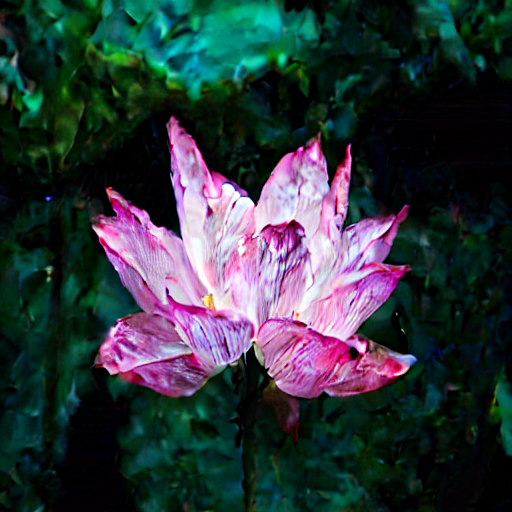

In [30]:
decodeds[0].save(
    "outputs/decodeds.gif",
    save_all=True,
    append_images=decodeds[1:],
    duration=50,
    loop=1,
)
decodeds[10].show()

In [53]:
# The reason we want to be able to specify start step
# target_prompt = "Photograph of lotus flower in a pond"
target_prompt = "Photograph of small lotus flower in a pond"

start_steps = []
for start_step in tqdm(range(0, 10)):  # inverted_latents.shape[0]
    img = sample(
        target_prompt,
        start_latents=inverted_latents[-(start_step + 1)][None],
        start_step=start_step,
        num_inference_steps=50,
    )[0]
    start_steps.append(img)

start_steps[0].save(
    "outputs/start_steps.gif",
    save_all=True,
    append_images=start_steps[1:],
    duration=50,
    loop=1,
)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:268: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 50/50 [00:07<00:00,  7.13it/s]
/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:559: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 10/10 [01:05<00:00,  6.53s/it]


100%|██████████| 120/120 [00:16<00:00,  7.38it/s]


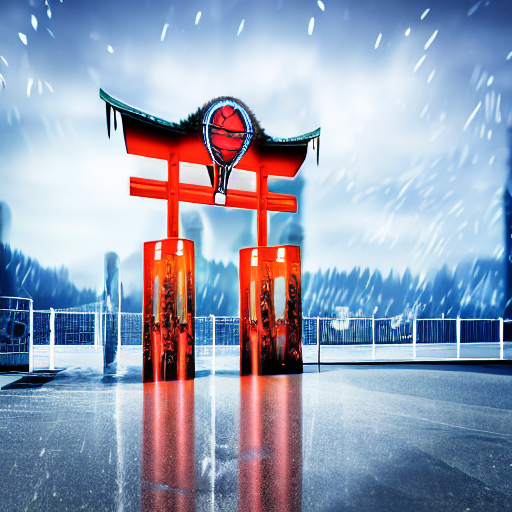

In [70]:
input_image = load_image(
    "https://gaijinpot.scdn3.secure.raxcdn.com/app/uploads/sites/4/2022/11/Miyajima-Shrine-iStock-500828709.jpg",
    size=(512, 512),
)
input_image_prompt = "Photograph of red shrine gate on the sea"
edit_prompt = "Photograph of red shrine gate cyber punk style"

edit(
    input_image,
    input_image_prompt,
    edit_prompt,
    num_steps=150,
    start_step=30,
    guidance_scale=5.5,
)

In [73]:
input_image = load_image(
    "https://gaijinpot.scdn3.secure.raxcdn.com/app/uploads/sites/4/2022/11/Miyajima-Shrine-iStock-500828709.jpg",
    size=(512, 512),
)
input_image_prompt = "Photograph of red shrine gate on the sea"
edit_prompt = "Photograph of red shrine gate cyber punk style"

with torch.no_grad():
    latent = pipe.vae.encode(T.to_tensor(input_image).unsqueeze(0).to(device) * 2 - 1)
    l = 0.18215 * latent.latent_dist.sample()
inverted_latents = invert(l, input_image_prompt, num_inference_steps=50)
inverted_latents.shape

start_steps = []
for start_step in tqdm(
    range(0, inverted_latents.shape[0])
):  # inverted_latents.shape[0]
    img = sample(
        edit_prompt,
        start_latents=inverted_latents[-(start_step + 1)][None],
        start_step=start_step,
        num_inference_steps=50,
    )[0]
    start_steps.append(img)

start_steps[0].save(
    "outputs/start_steps.gif",
    save_all=True,
    append_images=start_steps[1:],
    duration=50,
    loop=1,
)

 17%|█▋        | 8/48 [00:54<04:31,  6.78s/it]


KeyboardInterrupt: 

In [91]:
input_image = load_image(
    "https://gaijinpot.scdn3.secure.raxcdn.com/app/uploads/sites/4/2022/11/Miyajima-Shrine-iStock-500828709.jpg",
    size=(512, 512),
)
input_image_prompt = "Photograph of red shrine gate on the sea"
edit_prompt = "Photograph of red shrine gate on the sea, no background, object focus, background blur"

with torch.no_grad():
    latent = pipe.vae.encode(T.to_tensor(input_image).unsqueeze(0).to(device) * 2 - 1)
    l = 0.18215 * latent.latent_dist.sample()
inverted_latents = invert(l, input_image_prompt, num_inference_steps=50)
inverted_latents.shape

for step in range(20, inverted_latents.shape[0], 10):
    for cfg in range(1, 20, 5):
        start_step = 20
        img = sample(
            edit_prompt,
            start_latents=inverted_latents[-(step + 1)][None],
            start_step=step,
            num_inference_steps=50,
            guidance_scale=cfg,
        )[0]
        # save img

        img.save(f"outputs/variants/cfg={cfg}-step={step}.jpg")

100%|██████████| 10/10 [00:01<00:00,  7.42it/s]
